In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src/')
import dataset_prep

Import de la base de données

In [2]:
selected_columns = [
"nb_packets_sent",
"distance",
"distRealSR1",
"pos_y_rec_f",
"pos_y_rec",
"pos_x_rec_f",
"pos_x_rec",
"pos_x_send",
"pos_y_send",
"spd_x_send",
"spd_y_send",
"sendTime",
"receiver",
"sender",
"label"
]

In [3]:
df = dataset_prep.import_dataset('../../data/1416/merged1.csv', selected_columns)

Nombre de lignes avant nettoyage :  1048575
Nombre de lignes après nettoyage :  1038446


Analyse et vérification des données

In [4]:
senders = np.unique(df["sender"].values)
senders

array([   9,   15,   21, ..., 6687, 6693, 6699])

In [5]:
print(len(senders))

1116


In [6]:
# Copie de la bdd pour récuperer les colonnes sans impacter la vraie base de données

data_copy = df.copy()
data_copy = data_copy.drop(["label"], axis=1)

columns = data_copy.columns
columns

Index(['sendTime', 'sender', 'receiver', 'pos_x_send', 'pos_y_send',
       'spd_x_send', 'spd_y_send', 'pos_x_rec', 'pos_y_rec', 'pos_x_rec_f',
       'pos_y_rec_f', 'nb_packets_sent', 'distRealSR1', 'distance'],
      dtype='object')

Amélioration à faire :

Séléctionner seulement les sender avec value_counts > 20

Séparation de la base de données : diviser pour régner

In [7]:
# /!\ attention à bien utiliser la base de données rangée par sender pour limiter la perte de données
# Indice égal à 0, 1 ou 2
# Célia = 0
# Chléo = 1
# Thomas = 2

def split_data_in_3(df, indice):
    # Division de la bdd en 3
    split_data = np.array_split(df,3)

    # Division en plusieurs sous-bdd pour diminuer le temps de calcul par exécution
    #divided_data = np.array_split(split_data[indice],50)

    return split_data

/!\ à bien changer l'indice !!

In [8]:
divided_dataframes = split_data_in_3(df.sort_values("sender"),0)

In [9]:
len(divided_dataframes)

3

Création des séquences

In [8]:
def sequence_creation(df):
    senders_sequences = np.array()
    senders_label = np.array
    for sender in senders:
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        sequence_array = np.array

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On récupère la valeur du label pour ce sender
        label = df.loc[df['sender'] == sender]['label'].tolist()[0]
        if (length > 20):
            senders_label.append(label)

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length >= 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            sequence_array = np.append(sequence_array, np.array(sequence.values, dtype=object))
            #label_array.append(labels)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10
        
        if len(sequence_array)>0:
            senders_sequences = np.append(senders_sequences, np.array(sequence_array, dtype=object))

    
    return senders_sequences, senders_label

In [9]:
def flat_sequence_creation(df):
    senders_sequences = []
    senders_label = []

    for sender in senders:
        # Données d'un seul sender rangée en fonction de l'heure d'envoi
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")

        # On récupère la valeur du label pour ce sender
        """ On remplasse toute les valeur !=0 en 1 """
        if sender_data_sorted['label'].tolist()[0] != 0 :
            label=1
        else :
            label = sender_data_sorted['label'].tolist()[0]
        #On supprime les colonnes label et sender
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        
        #sequence_array = []

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            senders_sequences.append(np.array(sequence.values.tolist(), dtype=np.float32))
            senders_label.append(label)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10

    return senders_sequences, senders_label

/!\ à bien changer l'indice !!

In [10]:
sorted_dataset = df.sort_values("sender")

In [11]:
sequence_test, label_test = flat_sequence_creation(sorted_dataset)
#label_test

sequence_test, label_test = sequence_creation(df)

In [12]:
len(sequence_test)

102132

# Initialisation des données

In [13]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2023-02-03 15:04:06.857839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 15:04:06.857867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
# Transformation en array numpy
X = np.array(sequence_test)
y = np.array(label_test, dtype=np.float32)

In [ ]:
#X = X[:100]
#y = y[:100]

In [15]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (91918, 20, 13)
y_train :  (91918,)
X_test :  (10214, 20, 13)
y_test :  (10214,)


In [17]:
y_train

array([1., 1., 1., ..., 0., 0., 1.], dtype=float32)

# Modèle dense simple

In [53]:
# TODO amélioration du model dense avec du dropout ? 
simple_model = keras.Sequential([
    layers.Dense(128,input_shape=(20, 13), activation='relu'),
    #layers.BatchNormalization(), # les batchNormalization fond baisser l'accuracy 
    layers.Dense(256, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),#64
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear') # avec relu on perd un peu d'accuracy
])

In [54]:
print("INPUT")
[print(i.shape, i.dtype) for i in simple_model.inputs]
print("OUTPUT")
[print(o.shape, o.dtype) for o in simple_model.outputs]
print("LAYERS")
[print(l.name, l.input_shape, l.dtype) for l in simple_model.layers]

INPUT
(None, 20, 13) <dtype: 'float32'>
OUTPUT
(None, 20, 1) <dtype: 'float32'>
LAYERS
dense_17 (None, 20, 13) float32
dense_18 (None, 20, 128) float32
dense_19 (None, 20, 256) float32
dropout (None, 20, 64) float32
dense_20 (None, 20, 64) float32


[None, None, None, None, None]

In [55]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#opt = keras.optimizers.SGD(learning_rate=0.01)
simple_model.compile(loss='binary_crossentropy', optimizer="adam", metrics='accuracy')

In [56]:
history = simple_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20
503/503 [==============================] - 21s 39ms/step - loss: 8.5749 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407
Epoch 2/20
503/503 [==============================] - 19s 37ms/step - loss: 8.5753 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407
Epoch 3/20
503/503 [==============================] - 18s 35ms/step - loss: 8.5753 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407
Epoch 4/20
503/503 [==============================] - 18s 35ms/step - loss: 8.5753 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407
Epoch 5/20
503/503 [==============================] - 18s 36ms/step - loss: 8.5753 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407
Epoch 6/20
503/503 [==============================] - 19s 37ms/step - loss: 8.5753 - accuracy: 0.4441 - val_loss: 8.6270 - val_accuracy: 0.4407


<AxesSubplot:>

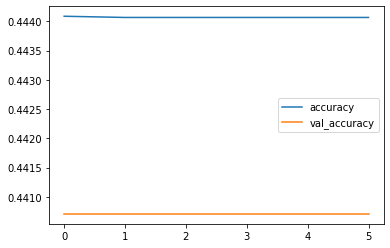

In [57]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

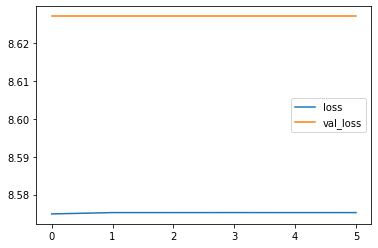

In [58]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [59]:
y_pred=simple_model.predict(X_test)
y_pred

array([[[ -9866.245],
        [ -9886.382],
        [ -9909.033],
        ...,
        [ -9891.693],
        [ -9884.717],
        [ -9867.86 ]],

       [[-10998.149],
        [-11000.644],
        [-10998.857],
        ...,
        [-10998.949],
        [-10999.287],
        [-10967.738]],

       [[-10282.078],
        [-10285.951],
        [-10263.607],
        ...,
        [-10288.735],
        [-10288.17 ],
        [-10288.827]],

       ...,

       [[ -9776.508],
        [ -9785.494],
        [ -9755.09 ],
        ...,
        [ -9793.449],
        [ -9784.892],
        [ -9754.303]],

       [[ -9718.923],
        [ -9726.351],
        [ -9719.216],
        ...,
        [ -9719.512],
        [ -9719.254],
        [ -9726.707]],

       [[-10107.289],
        [-10118.682],
        [-10092.285],
        ...,
        [-10127.26 ],
        [-10108.971],
        [-10093.412]]], dtype=float32)

In [60]:
eval=simple_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 1s 5ms/step - loss: 8.6307 - accuracy: 0.4405


[8.630658149719238, 0.44047385454177856]

# RNN

In [109]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    '''
    hidden_units : nombre de neurones dans la couche SimpleRNN
    dense_units : nombre de neurones dans la couche Dense
    activation : liste des deux fonctions d'activation
    '''
    #opt = keras.optimizers.SGD(learning_rate=0.01)
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
    model.add(SimpleRNN(32, activation=activation[0])) #32
    model.add(layers.BatchNormalization())
    model.add(Dense(64, activation=activation[1])) #64
    #model.add(layers.Dropout(0.3))
    model.add(Dense(units=dense_units, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    return model

#demo_model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

rnn_model = create_RNN(32, 1, (20, 13), activation=['relu', 'relu'])
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [110]:
history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20
503/503 [==============================] - 8s 12ms/step - loss: 0.3442 - accuracy: 0.8482 - val_loss: 0.5721 - val_accuracy: 0.7670
Epoch 2/20
503/503 [==============================] - 4s 9ms/step - loss: 0.3279 - accuracy: 0.8547 - val_loss: 0.6295 - val_accuracy: 0.6819
Epoch 3/20
503/503 [==============================] - 4s 9ms/step - loss: 0.3254 - accuracy: 0.8564 - val_loss: 0.3528 - val_accuracy: 0.8391
Epoch 4/20
503/503 [==============================] - 4s 9ms/step - loss: 0.3236 - accuracy: 0.8567 - val_loss: 0.3400 - val_accuracy: 0.8493
Epoch 5/20
503/503 [==============================] - 5s 10ms/step - loss: 0.3224 - accuracy: 0.8586 - val_loss: 0.3256 - val_accuracy: 0.8541
Epoch 6/20
503/503 [==============================] - 5s 9ms/step - loss: 0.3227 - accuracy: 0.8584 - val_loss: 0.4822 - val_accuracy: 0.7915
Epoch 7/20
503/503 [==============================] - 6s 12ms/step - loss: 0.3194 - accuracy: 0.8596 - val_loss: 0.3366 - val_accuracy: 0.8488
Epo

<AxesSubplot:>

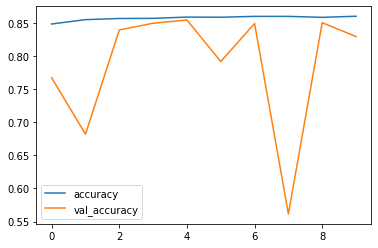

In [111]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

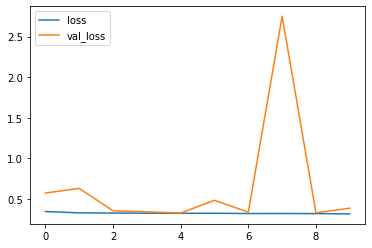

In [113]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [101]:
y_pred=rnn_model.predict(X_test)
y_pred

array([[0.48462105],
       [1.        ],
       [0.99997735],
       ...,
       [0.1412124 ],
       [0.9508745 ],
       [0.14230323]], dtype=float32)

In [102]:
# arrondir les prédictions avant de les evalués
y_pred = [0 if x < 0.5 else 1 for x in y_pred] 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85      4499
         1.0       0.94      0.80      0.86      5715

    accuracy                           0.86     10214
   macro avg       0.86      0.87      0.86     10214
weighted avg       0.87      0.86      0.86     10214



In [103]:
eval=rnn_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 2s 5ms/step - loss: 0.3120 - accuracy: 0.8586


[0.3119809627532959, 0.8586254119873047]

# Test LSTM

In [160]:
lstm_model = keras.Sequential([
    layers.Dense(32, input_shape=(20,13), activation='relu'),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    #layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [161]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
lstm_model.summary()

In [162]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20
503/503 [==============================] - 74s 142ms/step - loss: 0.3780 - accuracy: 0.8294 - val_loss: 0.3549 - val_accuracy: 0.8477
Epoch 2/20
503/503 [==============================] - 140s 278ms/step - loss: 0.3766 - accuracy: 0.8343 - val_loss: 0.3616 - val_accuracy: 0.8503
Epoch 3/20
503/503 [==============================] - 150s 299ms/step - loss: 0.3541 - accuracy: 0.8416 - val_loss: 0.3382 - val_accuracy: 0.8513
Epoch 4/20
503/503 [==============================] - 143s 285ms/step - loss: 0.3486 - accuracy: 0.8452 - val_loss: 0.3356 - val_accuracy: 0.8508
Epoch 5/20
503/503 [==============================] - 159s 317ms/step - loss: 0.3479 - accuracy: 0.8411 - val_loss: 0.3500 - val_accuracy: 0.8515
Epoch 6/20
503/503 [==============================] - 136s 271ms/step - loss: 0.3474 - accuracy: 0.8444 - val_loss: 0.3356 - val_accuracy: 0.8258
Epoch 7/20
503/503 [==============================] - 95s 190ms/step - loss: 0.3395 - accuracy: 0.8481 - val_loss: 0.3465 - v

<AxesSubplot:>

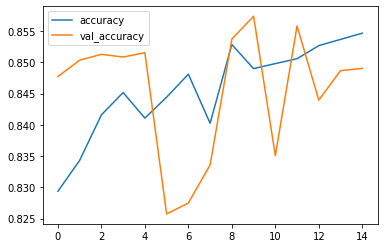

In [168]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

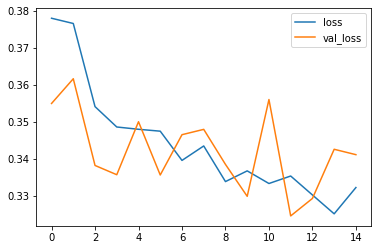

In [169]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [170]:
y_pred=lstm_model.predict(X_test)
y_pred

array([[0.59349227],
       [0.99996895],
       [0.9998843 ],
       ...,
       [0.12268433],
       [0.99964005],
       [0.12643489]], dtype=float32)

In [171]:
# arrondir les prédictions avant de les evalués
y_pred = [0 if x < 0.5 else 1 for x in y_pred] 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85      4499
         1.0       0.94      0.79      0.86      5715

    accuracy                           0.85     10214
   macro avg       0.86      0.86      0.85     10214
weighted avg       0.87      0.85      0.86     10214



In [172]:
eval=lstm_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 3s 10ms/step - loss: 0.3359 - accuracy: 0.8547


[0.33590832352638245, 0.8547092080116272]

# Mélange SimpleRNN et LSTM

In [182]:
lstm_rnn_model = keras.Sequential([
    layers.Dense(32,input_shape=(20,13), activation='relu'),
    layers.LSTM(128, return_sequences=True, activation='relu'), # return_sequences à True pour que la sortie soit de dimension 3
    layers.LSTM(128, return_sequences=True, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'), #64
    layers.SimpleRNN(64,activation='relu', return_sequences=True),
    layers.SimpleRNN(32,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
#opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [183]:
history = lstm_rnn_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20
503/503 [==============================] - 47s 87ms/step - loss: 0.5854 - accuracy: 0.6671 - val_loss: 2.2392 - val_accuracy: 0.5593
Epoch 2/20
503/503 [==============================] - 39s 78ms/step - loss: 0.4573 - accuracy: 0.7783 - val_loss: 1.2829 - val_accuracy: 0.4407
Epoch 3/20
503/503 [==============================] - 39s 78ms/step - loss: 0.4372 - accuracy: 0.7902 - val_loss: 0.4688 - val_accuracy: 0.7835
Epoch 4/20
503/503 [==============================] - 40s 80ms/step - loss: 0.4135 - accuracy: 0.8033 - val_loss: 0.5892 - val_accuracy: 0.6831
Epoch 5/20
503/503 [==============================] - 40s 79ms/step - loss: 0.3712 - accuracy: 0.8312 - val_loss: 0.6042 - val_accuracy: 0.7164
Epoch 6/20
503/503 [==============================] - 40s 79ms/step - loss: 0.3515 - accuracy: 0.8415 - val_loss: 0.6912 - val_accuracy: 0.6763
Epoch 7/20
503/503 [==============================] - 40s 80ms/step - loss: 0.3447 - accuracy: 0.8448 - val_loss: 0.5253 - val_accuracy:

<AxesSubplot:>

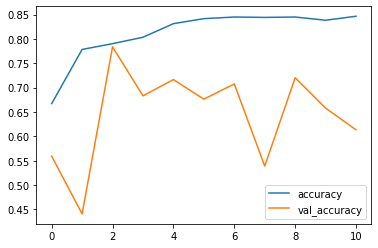

In [189]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

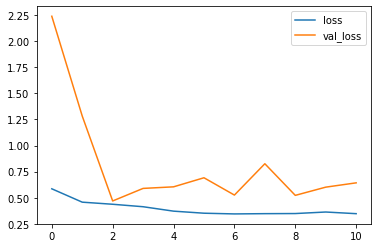

In [190]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [191]:
y_pred=lstm_rnn_model.predict(X_test)
y_pred

array([[0.6945452 ],
       [0.9974154 ],
       [0.9844209 ],
       ...,
       [0.40801007],
       [0.94962376],
       [0.42922425]], dtype=float32)

In [192]:
# arrondir les prédictions avant de les evalués
y_pred = [0 if x < 0.5 else 1 for x in y_pred] 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78      4499
         1.0       0.88      0.70      0.78      5715

    accuracy                           0.78     10214
   macro avg       0.79      0.79      0.78     10214
weighted avg       0.80      0.78      0.78     10214



In [193]:
eval=lstm_rnn_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 3s 11ms/step - loss: 0.4687 - accuracy: 0.7779


[0.46868398785591125, 0.7778539061546326]